In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Load data from the GitHub raw URL
url = "https://raw.githubusercontent.com/btenneson/public_projects/main/nba_logreg2.csv"
data = pd.read_csv(url)

# Load the CSV file from your local directory
# Replace 'your_file.csv' with the actual path to your CSV file
# data = pd.read_csv("G:\\My Drive\\research\\kaggle\\exercises-lswzxogistic-regression-exercise-1\\exercises-logistic-regression-exercise-1\\data\\nba_logreg2.csv")

# Calculate the number of NaNs in the dataset before filling
# nan_counts_before = data.isna().sum().sum()

# Replace NaNs with the mean of the respective columns
data_filled = data.apply(lambda col: col.fillna(col.mean()) if col.dtype in ['float64', 'int64'] else col)

# Calculate the number of NaNs in the dataset after filling
# nan_counts_after = data_filled.isna().sum().sum()

# Calculate the number of replacements made
# replacements_made = nan_counts_before - nan_counts_after

# replacements_made

data = data_filled

# Define the objective function to maximize the absolute correlation
def objective_function(bias, data):
    # Calculate synthetic scores
    synthetic_scores = data.iloc[:, 1:].dot(bias)
    
    # Correlation with the first column
    correlation = np.corrcoef(data.iloc[:, 0], synthetic_scores)[0, 1]
    
    # Minimize the negative absolute correlation
    return -abs(correlation)

# Initial guess for the bias vector (random values, no need to normalize)
n_minus_1 = data.shape[1] - 1  # Assuming data includes the first column
initial_bias = np.random.rand(n_minus_1)

# Minimization process
result = minimize(
    objective_function,
    initial_bias,
    args=(data,),
    method='Powell',
    options={'disp': True}
)

# Check results
if result.success:
    optimized_bias = result.x
    print("Optimized bias vector:", optimized_bias)
    print("Achieved correlation:", -result.fun)  # Negate to show maximized correlation
else:
    print("Optimization failed:", result.message)


Optimization terminated successfully.
         Current function value: -0.449620
         Iterations: 18
         Function evaluations: 3227
Optimized bias vector: [  1.51966675  -1.36963415  -7.28131835 -16.38271207  16.36019214
   2.17084322 113.49661428 -38.96630921   0.12032873  19.25401376
  -5.96441588   0.50263807  33.05395015  -1.41149859  -4.59386758
   7.66123955   1.35267016  16.62366572  -6.31896723]
Achieved correlation: 0.4496196679006047


In [2]:
len(optimized_bias)

19

Best Threshold: 0.52
Best Accuracy: 71.55%
Confusion Matrix:
 [[276 232]
 [149 682]]
F1 Score: 0.7816618911174785
Precision: 0.7461706783369803
Recall: 0.8206979542719615
AUC: 0.7697478135630158


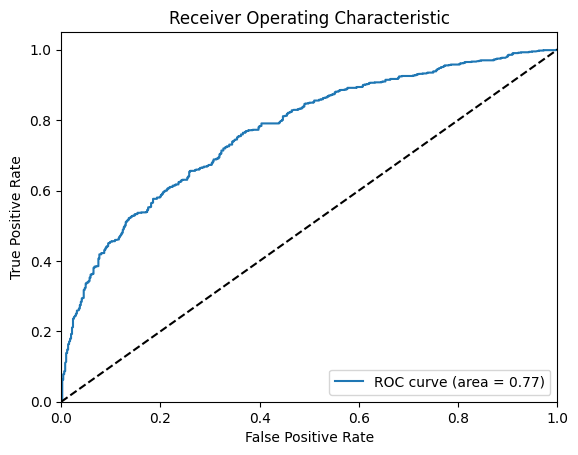

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and 'synthetic_scores' column is calculated
if 'synthetic_scores' not in data.columns:
    # Placeholder for your synthetic_scores calculation logic
    synthetic_scores = data.iloc[:, 1:].dot(optimized_bias)
    data['synthetic_scores'] = synthetic_scores

# Initialize the linear regression model
model = LinearRegression()

# The input X needs to be reshaped for fitting with sklearn (single feature)
X = data['synthetic_scores'].values.reshape(-1, 1)  # Predictor - synthetic scores
y = data.iloc[:, 0].values  # Response variable from the first column

# Fit the model
model.fit(X, y)

# Use the model to make predictions
fitted_scores = model.predict(X)

# Function to calculate accuracy for a given threshold
def calculate_accuracy(threshold):
    y_pred = (fitted_scores >= threshold).astype(int)
    return accuracy_score(y, y_pred)

# Test thresholds from 0.0 to 1.0 in small increments
thresholds = np.arange(0.0, 1.01, 0.01)
accuracies = [calculate_accuracy(t) for t in thresholds]

# Find the threshold with the highest accuracy
best_threshold_index = np.argmax(accuracies)
best_threshold = thresholds[best_threshold_index]
best_accuracy = accuracies[best_threshold_index]

# Generate predictions using the best threshold
best_predicted_labels = (fitted_scores >= best_threshold).astype(int)
data['Optimized_Predicted'] = best_predicted_labels

# Print results
print(f"Best Threshold: {best_threshold}")
print(f"Best Accuracy: {best_accuracy * 100:.2f}%")

# Additional metrics
conf_matrix = confusion_matrix(y, best_predicted_labels)
f1 = f1_score(y, best_predicted_labels)
precision = precision_score(y, best_predicted_labels)
recall = recall_score(y, best_predicted_labels)
auc = roc_auc_score(y, fitted_scores)

print("Confusion Matrix:\n", conf_matrix)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y, fitted_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [5]:
import lightgbm as lgb

# Assuming 'synthetic_scores' is already calculated and part of your DataFrame
X = data['synthetic_scores'].values.reshape(-1, 1)  # Use synthetic scores as features
y = data.iloc[:, 0].values  # The target variable

# Convert the data into LightGBM dataset format
lgb_train = lgb.Dataset(X, label=y)

# Define LightGBM parameters
params = {
    'objective': 'binary',  # Assuming the target is binary
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the LightGBM model
gbm = lgb.train(params, lgb_train, num_boost_round=100)


[LightGBM] [Info] Number of positive: 831, number of negative: 508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.620612 -> initscore=0.492148
[LightGBM] [Info] Start training from score 0.492148


Best Threshold: 0.54
Best Accuracy: 76.25%
Confusion Matrix:
 [[355 153]
 [165 666]]
F1 Score: 0.8072727272727273
Precision: 0.8131868131868132
Recall: 0.8014440433212996
AUC: 0.8364211129745965


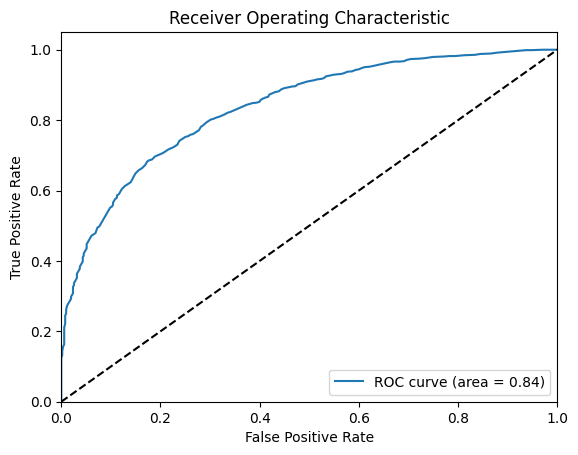

In [6]:
# Make predictions
fitted_scores = gbm.predict(X)

# Function to calculate accuracy for a given threshold
def calculate_accuracy(threshold):
    y_pred = (fitted_scores >= threshold).astype(int)
    return accuracy_score(y, y_pred)

# Test thresholds from 0.0 to 1.0 in small increments
thresholds = np.arange(0.0, 1.01, 0.01)
accuracies = [calculate_accuracy(t) for t in thresholds]

# Find the threshold with the highest accuracy
best_threshold_index = np.argmax(accuracies)
best_threshold = thresholds[best_threshold_index]
best_accuracy = accuracies[best_threshold_index]

# Generate predictions using the best threshold
best_predicted_labels = (fitted_scores >= best_threshold).astype(int)
data['Optimized_Predicted'] = best_predicted_labels

# Print results
print(f"Best Threshold: {best_threshold}")
print(f"Best Accuracy: {best_accuracy * 100:.2f}%")

# Additional metrics
conf_matrix = confusion_matrix(y, best_predicted_labels)
f1 = f1_score(y, best_predicted_labels)
precision = precision_score(y, best_predicted_labels)
recall = recall_score(y, best_predicted_labels)
auc = roc_auc_score(y, fitted_scores)

print("Confusion Matrix:\n", conf_matrix)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y, fitted_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Testing by spiltting training data

Optimization terminated successfully.
         Current function value: -0.449488
         Iterations: 17
         Function evaluations: 3132
Optimized bias vector: [ 4.89244840e-01 -4.59589811e-01 -2.37789028e+00 -6.48710039e+00
  5.90302021e+00  7.60310720e-01  3.30418191e+01 -1.14240282e+01
  4.29360001e-02  7.68576865e+00 -2.99215407e+00  1.42613826e-01
  5.14665011e+00 -5.71761564e+00  3.97190536e+00  2.63966837e+00
  3.11763445e-02  5.46732802e+00 -2.39371831e+00]
Achieved correlation: 0.44948797570829657
[LightGBM] [Info] Number of positive: 656, number of negative: 415
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1071, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.612512 -> initscore=0.457882
[LightGBM] [Info] Start training from score 0.457882

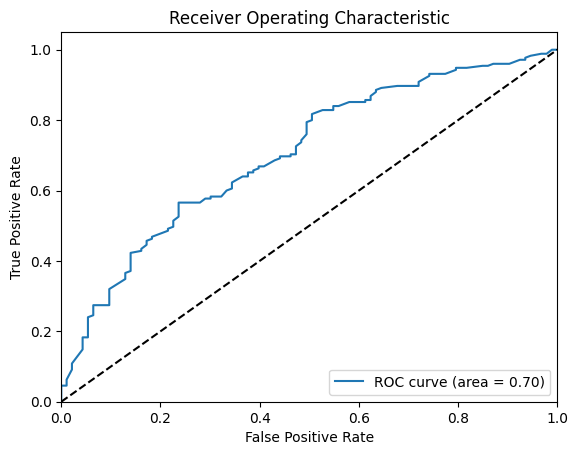

In [7]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
import lightgbm as lgb
import matplotlib.pyplot as plt

# Load data from the GitHub raw URL
url = "https://raw.githubusercontent.com/btenneson/public_projects/main/nba_logreg2.csv"
data = pd.read_csv(url)

# Replace NaNs with the mean of the respective columns
data_filled = data.apply(lambda col: col.fillna(col.mean()) if col.dtype in ['float64', 'int64'] else col)
data = data_filled

# Define the objective function to maximize the absolute correlation
def objective_function(bias, data):
    synthetic_scores = data.iloc[:, 1:].dot(bias)
    correlation = np.corrcoef(data.iloc[:, 0], synthetic_scores)[0, 1]
    return -abs(correlation)

# Initial guess for the bias vector (random values)
n_minus_1 = data.shape[1] - 1
initial_bias = np.random.rand(n_minus_1)

# Minimization process
result = minimize(
    objective_function,
    initial_bias,
    args=(data,),
    method='Powell',
    options={'disp': True}
)

# Check results
if result.success:
    optimized_bias = result.x
    print("Optimized bias vector:", optimized_bias)
    print("Achieved correlation:", -result.fun)
else:
    print("Optimization failed:", result.message)

# Assuming 'synthetic_scores' is already calculated and part of your DataFrame
synthetic_scores = data.iloc[:, 1:].dot(optimized_bias)
data['synthetic_scores'] = synthetic_scores

# Split the data into training and test sets
X = data['synthetic_scores'].values.reshape(-1, 1)
y = data.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the training data into LightGBM dataset format
lgb_train = lgb.Dataset(X_train, label=y_train)

# Define LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the LightGBM model
gbm = lgb.train(params, lgb_train, num_boost_round=100)

# Make predictions on the test set
fitted_scores = gbm.predict(X_test)

# Function to calculate accuracy for a given threshold
def calculate_accuracy(threshold):
    y_pred = (fitted_scores >= threshold).astype(int)
    return accuracy_score(y_test, y_pred)

# Test thresholds from 0.0 to 1.0 in small increments
thresholds = np.arange(0.0, 1.01, 0.01)
accuracies = [calculate_accuracy(t) for t in thresholds]

# Find the threshold with the highest accuracy
best_threshold_index = np.argmax(accuracies)
best_threshold = thresholds[best_threshold_index]
best_accuracy = accuracies[best_threshold_index]

# Generate predictions using the best threshold
best_predicted_labels = (fitted_scores >= best_threshold).astype(int)

# Print results
print(f"Best Threshold: {best_threshold}")
print(f"Best Accuracy on Test Set: {best_accuracy * 100:.2f}%")

# Additional metrics
conf_matrix = confusion_matrix(y_test, best_predicted_labels)
f1 = f1_score(y_test, best_predicted_labels)
precision = precision_score(y_test, best_predicted_labels)
recall = recall_score(y_test, best_predicted_labels)
auc = roc_auc_score(y_test, fitted_scores)

print("Confusion Matrix:\n", conf_matrix)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, fitted_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Iteration 1/1071
[LightGBM] [Info] Number of positive: 753, number of negative: 452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1205, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624896 -> initscore=0.510383
[LightGBM] [Info] Start training from score 0.510383
Iteration 2/1071
[LightGBM] [Info] Number of positive: 753, number of negative: 452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1205, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624896 -> initscore=0.510383
[LightGBM] [Info] Start training from score 0.510

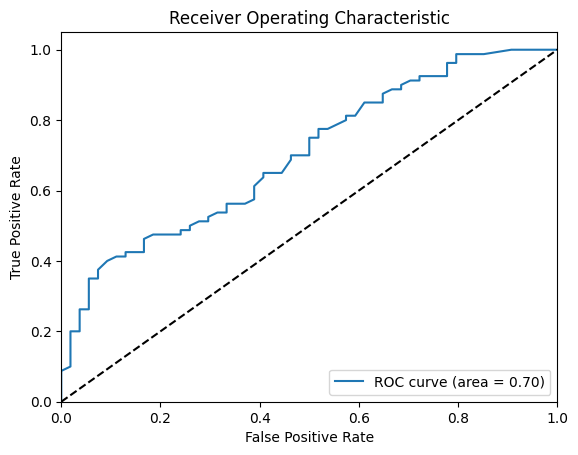

In [8]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
import lightgbm as lgb
import matplotlib.pyplot as plt

# Load data from the GitHub raw URL
url = "https://raw.githubusercontent.com/btenneson/public_projects/main/nba_logreg2.csv"
data = pd.read_csv(url)

# Replace NaNs with the mean of the respective columns
data_filled = data.apply(lambda col: col.fillna(col.mean()) if col.dtype in ['float64', 'int64'] else col)
data = data_filled

# Define the objective function to maximize the absolute correlation
def objective_function(bias, data):
    synthetic_scores = data.iloc[:, 1:].dot(bias)
    correlation = np.corrcoef(data.iloc[:, 0], synthetic_scores)[0, 1]
    return -abs(correlation)

# Set the number of iterations (M)
user_input = 1  # Adjust this multiplier as needed
M = int(0.8 * data.shape[0] * user_input)

# Initialize lists to store results
accuracy_list = []
f1_list = []
precision_list = []
recall_list = []
auc_list = []

# Repeat the procedure M times
for i in range(M):
    print(f"Iteration {i+1}/{M}")

    # Initial guess for the bias vector (random values)
    n_minus_1 = data.shape[1] - 1
    initial_bias = np.random.rand(n_minus_1)

    # Minimization process
    result = minimize(
        objective_function,
        initial_bias,
        args=(data,),
        method='Powell',
        options={'disp': False}  # Set to False to reduce output during multiple runs
    )

    # Check results
    if result.success:
        optimized_bias = result.x
    else:
        print("Optimization failed:", result.message)
        continue

    # Calculate synthetic scores
    synthetic_scores = data.iloc[:, 1:].dot(optimized_bias)
    data['synthetic_scores'] = synthetic_scores

    # Split the data into training and test sets
    X = data['synthetic_scores'].values.reshape(-1, 1)
    y = data.iloc[:, 0].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=i)  # Different random_state for each iteration

    # Convert the training data into LightGBM dataset format
    lgb_train = lgb.Dataset(X_train, label=y_train)

    # Define LightGBM parameters
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9
    }

    # Train the LightGBM model
    gbm = lgb.train(params, lgb_train, num_boost_round=100)

    # Make predictions on the test set
    fitted_scores = gbm.predict(X_test)

    # Find the best threshold based on accuracy
    thresholds = np.arange(0.0, 1.01, 0.01)
    accuracies = [(fitted_scores >= t).astype(int) for t in thresholds]
    accuracies = [accuracy_score(y_test, y_pred) for y_pred in accuracies]

    best_threshold_index = np.argmax(accuracies)
    best_threshold = thresholds[best_threshold_index]
    best_predicted_labels = (fitted_scores >= best_threshold).astype(int)

    # Calculate and store metrics
    accuracy_list.append(accuracies[best_threshold_index])
    f1_list.append(f1_score(y_test, best_predicted_labels))
    precision_list.append(precision_score(y_test, best_predicted_labels))
    recall_list.append(recall_score(y_test, best_predicted_labels))
    auc_list.append(roc_auc_score(y_test, fitted_scores))

# Final summary
print("\nFinal Summary:")
print(f"Average Accuracy: {np.mean(accuracy_list) * 100:.2f}%")
print(f"Average F1 Score: {np.mean(f1_list):.2f}")
print(f"Average Precision: {np.mean(precision_list):.2f}")
print(f"Average Recall: {np.mean(recall_list):.2f}")
print(f"Average AUC: {np.mean(auc_list):.2f}")

# Plot ROC Curve for the final iteration
fpr, tpr, thresholds = roc_curve(y_test, fitted_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_list[-1])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
